In [6]:
from scipy.io import loadmat
import mne
import numpy as np
import matplotlib.pyplot as plt
from utils import *

%matplotlib inline

mne.set_log_level(verbose="ERROR")

In [7]:
FCz_persubject = {}
FCz_grandaverage = None

l_freq=1.0
h_freq=10.0
re_fs=64
tmin=-0.1
tmax=0.85

session = 1
subjects = np.arange(1,6)

grand_average_epochs = []

In [8]:
for subject in subjects:
    fpath = f"data/sub%02d_ses%d.mat" % (subject, session)

    mat_raw = loadmat(fpath, simplify_cells=1)
    mat_data = mat_raw['run']
    epochs_list = []

    for trial in mat_data:

        # extract trial data and metadata
        eegdata = trial['eeg'].transpose()
        header = trial['header']

        sfreq = header['SampleRate']
        ch_names = list(header['Label'][:-1])
        ch_types = ['eeg'] * len(ch_names)

        info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
        info.set_montage("standard_1020")

        # Create MNE Raw object
        raw = mne.io.RawArray(eegdata, info)

        # Filter the data
        filtdata = raw.copy().filter(l_freq=l_freq, h_freq=h_freq)

        events = header['EVENT']
        events_pos = np.array(events['POS'], dtype=int)
        events_type = np.array(events['TYP'], dtype=int)

        nevents = len(events_pos)
        eventsarr = np.zeros([nevents, 3], dtype=int)
        eventsarr[:,0]= events_pos
        eventsarr[:,2] = events_type

        # decimfactor = sfreq / re_fs
        # epoch = mne.Epochs(raw=filtdata, events = eventsarr, tmin=tmin, tmax=tmax, decim=decimfactor, preload=True)      
        
        epoch = mne.Epochs(raw=filtdata, events = eventsarr, tmin=tmin, tmax=tmax, preload=True, detrend=1)      
        
        epochs_list.append(epoch)
        grand_average_epochs.append(epoch)
    
    # Concatenate all epochs into a single Raw object
    epochs = mne.concatenate_epochs(epochs_list)
    
    correct = epochs[['5','10']].average()
    erroneous = epochs[['6','9']].average()

    errmincorr = mne.combine_evoked([erroneous, correct], weights=[1, -1])
    FCz = errmincorr.get_data(picks=['FCz'])
    FCz_persubject.update({subject:FCz})


epochs = mne.concatenate_epochs(grand_average_epochs)
correct = epochs[['5','10']].average()
erroneous = epochs[['6','9']].average()

errmincorr = mne.combine_evoked([erroneous, correct], weights=[1, -1])

FCz_grandaverage = errmincorr.get_data(picks=['FCz'])

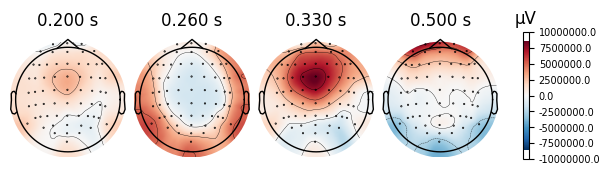

In [9]:
times=[0.2, 0.26, 0.33, 0.5]

errmincorr.plot_topomap(times=times, show=0)

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
C:\Users\dimitar\AppData\Local\Temp\ipykernel_15136\3266282683.py:8: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("Amplitude [$\mu$V]")


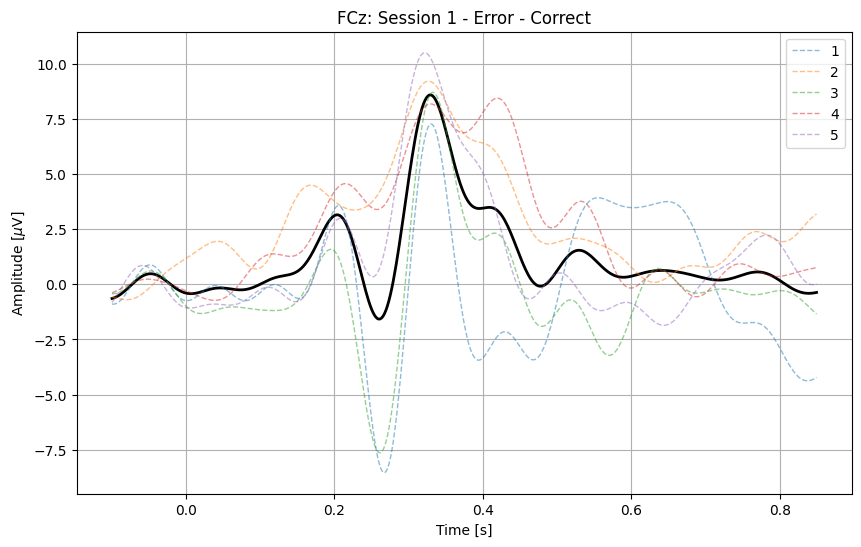

In [11]:
times = errmincorr.times

plt.figure(figsize=(10,6))
plt.plot(times, FCz_grandaverage.flatten(), c='k', lw=2)
for sub, data in FCz_persubject.items():
    plt.plot(times, data.flatten(), ls='--', lw=1, alpha=0.5, label=sub)
plt.grid()
plt.ylabel("Amplitude [$\mu$V]")
plt.xlabel("Time [s]")
plt.title("FCz: Session 1 - Error - Correct")
plt.legend()
plt.show()